<a href="https://colab.research.google.com/github/TomMaullin/BLM/blob/master/FS_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FS implementation in python

This code implements the Fisher Scoring algorithm for estimating the parameters of linear mixed effects models as described in [Demidenko 2013](https://www.wiley.com/en-us/Mixed+Models%3A+Theory+and+Applications+with+R%2C+2nd+Edition-p-9781118091579).

## Pip Installations

Pip install everything.

In [2]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install matplotlib


## Python Imports




We need:
 - `numpy` for matrix handling.
 - `scipy` for sparse matrix functions.
 - `pandas` for quick reading and writing of csv files.
 - `os` and `sys` for basic commandline functions
 - `time` for timing functions.
 - `matplotlib` for making displays.

In [0]:
import numpy as np
import cvxopt
import pandas as pd
import os
import time
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import sys

## Toy Dataset

This section read ins and formats a toy dataset. The files used here were generated in `R` and with **True** values (those with postfix `True`) being those used to generate the data and **Estimated** (those with postfix `REst`) values being the estimates `R`'s `lmer` package generated from this data.

In [4]:
# Make a data directory
if not os.path.isdir('/Data'):
  os.mkdir('/Data')
  
os.chdir('/Data')

# Clone small git repo containg some csv files.
if not os.path.isdir('/Data/BLMM-testdata'):
  !git clone https://github.com/TomMaullin/BLMM-testdata.git
  

Cloning into 'BLMM-testdata'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (14/14), done.



### Z matrix

The below reads in Z and makes an image of Z transpose.


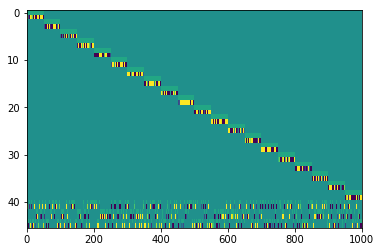

In [5]:
# Read in random effects design matrix and convert it into it's sparse format in
# cvxopt.
Z_3col=pd.read_csv('/Data/BLMM-testdata/Z_3col.csv',header=None).values
Z = scipy.sparse.csr_matrix((Z_3col[:,2].tolist(), \
                            ((Z_3col[:,0]-1).astype(np.int64), \
                             (Z_3col[:,1]-1).astype(np.int64))))

# Create an image of Z'
imshow(Z.toarray().transpose(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')



### Estimated Random Effects matrix

The below reads in the Random effects variance predicted by `R`'s `lmer`.

In [0]:
# Read in estimated variance
RFXVar_REst = pd.read_csv('/Data/BLMM-testdata/estd_rfxvar.csv',header=None).values

### Y vector

The response vector is read in here:

In [0]:
Y=pd.read_csv('/Data/BLMM-testdata/Y.csv',header=None).values

### X matrix

The fixed effects design matrix is read in here. It consists of an intercept and two random (Gaussian) columns.


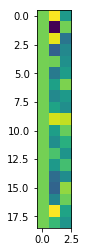

In [8]:
X=pd.read_csv('/Data/BLMM-testdata/X.csv',header=None).values

# Image of the first 20 rows of X
imshow(X[1:20,:])

### Number of Levels and Parameters

The number of levels is given by a vector with one entry for each grouping factor. e.g. nlevels=[10,2] means there are 10 levels for factor 1 and 2 levels for factor 2. 

The number of parameters is given by a vector with one entry for each grouping factor. e.g. nparams=[3,4] means there are 3 variables for factor 1 and 4 variables for factor 2.

In [0]:
nlevels = np.array([20,3])
nparams = np.array([2,2])

### True b values

The true recorded values of the random effects b vector in this example.

In [0]:
b_True=pd.read_csv('/Data/BLMM-testdata/true_b.csv',header=None).values

### True beta values

The true fixed effects parameters used to generate this example.

In [0]:
beta_True=pd.read_csv('/Data/BLMM-testdata/true_beta.csv',header=None).values

### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. 

In [12]:
# Z transpose Z
print(Z.shape)
ZtZ = np.matmul(Z.toarray().transpose(),Z.toarray()) # This works for products involving sparse
# Sparse 
# ZtZ = Z.transpose() * Z

# Z transpose X
XtZ = np.matmul(X.transpose(),Z.toarray())

# X transpose Z
ZtX = np.matmul(Z.toarray().transpose(),X)

# ZtY
ZtY = np.matmul(Z.toarray().transpose(),Y)

# YtZ
YtZ = np.matmul(Y.transpose(),Z.toarray())

# XtX
XtX = np.matmul(X.transpose(),X)

# XtY
XtY = np.matmul(X.transpose(),Y)

# YtX
YtX = np.matmul(Y.transpose(),X)

# YtX
YtY = np.matmul(Y.transpose(),Y)

(1000, 46)


## Helper Functions

This section contains miscellaneous functions used to help the `FS` function including functions to work out the duplication matrix.


###Matrix to Vector function

This function takes in a matrix and vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ d & e & f \\ g & h & i \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ d \\ g \\ b \\ e \\ h \\ c \\ f \\ i \end{bmatrix}$$.

In [0]:
def mat2vec(matrix):
  
  #Return vectorised matrix
  return(matrix.transpose().reshape(matrix.shape[0]*matrix.shape[1],1))

# Example:
#matrix = np.random.randn(3,3)
#print(matrix)
#print(mat2vec(matrix))

###Matrix to Vector function

This function takes in a (symmetric, square) matrix and half-vectorizes it (i.e. transforms it to a vector of each of the columns of the matrix, below and including the diagonal, stacked on top of one another). Example:

$$\begin{bmatrix} a & b & c \\ b & d & e \\ c & e & f \\\end{bmatrix} \rightarrow \begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}$$.

In [14]:
def mat2vech(matrix):
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0])
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Return vectorised half-matrix
  return(np.array([matrix[rowinds[perm],colinds[perm]]]).transpose())

# Example:
matrix = np.random.randn(3,3)
print(matrix*matrix.transpose())
print(mat2vech(matrix*matrix.transpose()))

[[ 0.80505903 -0.22851314  0.3198389 ]
 [-0.22851314  0.30562296 -0.63659538]
 [ 0.3198389  -0.63659538  0.24405396]]
[[ 0.80505903]
 [-0.22851314]
 [ 0.3198389 ]
 [ 0.30562296]
 [-0.63659538]
 [ 0.24405396]]


In [0]:
def vec2mat(vec):
  
  # Return matrix
  return(vec.reshape(np.int64(np.sqrt(vec.shape[0])),np.int64(np.sqrt(vec.shape[0]))).transpose())

# Example
#vec = np.array([[1,2,3,4]]).transpose()
#mat = vec2mat(vec)
#print(vec)
#print(mat)

In [0]:
def vech2mat(vech):
  
  # dimension of matrix
  n = np.int64((-1+np.sqrt(1+8*vech.shape[0]))/2)
  matrix = np.zeros((n,n))
  
  # Get lower triangular indices
  rowinds, colinds = np.tril_indices(matrix.shape[0])
  
  # They're in the wrong order so we need to order them
  # To do this we first hash them
  indhash = colinds*matrix.shape[0]+rowinds
  
  # Sort permutation
  perm=np.argsort(indhash)
  
  # Assign values to lower half
  matrix[rowinds[perm],colinds[perm]] = vech.reshape(vech.shape[0])
  
  # Assign values to upper half
  matrix[colinds[perm],rowinds[perm]] = vech.reshape(vech.shape[0])
  
  # Return vectorised half-matrix
  return(matrix)

# Example:
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#matrix = vech2mat(vech)
#print(vech)
#print(matrix)

In [0]:
def vec2vech(vec):
  
  # Return vech
  return(mat2vech(vec2mat(vec)))

# Example
#vec = np.array([[1],[2],[3],[2],[4],[5],[3],[5],[6]])
#vech = vec2vech(vec)

#print(vec)
#print(vech)

In [0]:
def vech2vec(vech):
  
  # Return vec
  return(mat2vec(vech2mat(vech)))

# Example
#vech = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])
#vec = vech2vec(vech)

#print(vech)
#print(vec)

In [0]:
def dupMat(n):
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = vech2vec(vech)
  
  # Make D (sparse one hot encoded vec)
  D = scipy.sparse.csr_matrix((np.ones(n**2),(np.arange(n**2),np.int64(vec).reshape(vec.shape[0]))))
  
  return(D)

# Example
#print(dupMat(3))

In [0]:
def invDupMat(n):
  
  
  # Make vech of 1:(n(n+1)/2)
  vech = np.arange(n*(n+1)/2)
  
  # Convert to vec
  vec = np.int64(vech2vec(vech))
  vec = vec.reshape(vec.shape[0])
  
  # Work out frequency of each entry
  freq = 1/np.bincount(vec)
  
  # Work out duplication matrix
  D = scipy.sparse.csr_matrix((freq[vec],(vec,np.arange(n**2))))
  
  return(D)

# Example
#print(invDupMat(3))

In [21]:
def blockInverse(matrix, blockSize, numBlocks):

  invMatrix = scipy.sparse.csr_matrix((np.array([]), (np.array([]),np.array([]))),shape=matrix.shape)
  
  # For each level, invert the corresponding block on the diagonal
  for i in range(numBlocks):
    
    # The block is nparams by nparams
    blockInds = np.ix_(np.arange(i*blockSize,(i+1)*blockSize),np.arange(i*blockSize,(i+1)*blockSize))
    
    # Get the block
    block = matrix[blockInds]
    
    # Replace it with it's inverse
    invMatrix[blockInds]=scipy.sparse.linalg.inv(block)
    
  return(invMatrix)

# Example - need to have loaded in data first

# Get ZtZ just for the first grouping factor
firstFactorIndices = np.ix_(np.arange(nlevels[0]*nparams[0]),np.arange(nlevels[0]*nparams[0]))
ZtZ_f1 = ZtZ[firstFactorIndices]

# Compute the block inverse for ZtZ_f1
t1 = time.time()
ZtZ_f1_inv = blockInverse(matrix=ZtZ_f1, blockSize=nparams[0], numBlocks=nlevels[0])
t2 = time.time()
blockInverse_time = t2-t1

# Compare it to the inverse scipy would calculate
t1 = time.time()
ZtZ_f1_inv_sp = scipy.sparse.linalg.inv(ZtZ_f1)
t2 = time.time()
scipyInverse_time = t2-t1

print(blockInverse_time)
print(scipyInverse_time)


TypeError: ignored

In [0]:
def recursiveInverse(M, nparams, nlevels):
  
  # Work out qc
  qc = nparams[-1]*nlevels[-1]
  
  # Make q
  q = M.shape[0]
  
  # Get A, B and C where M=[[A,B],[B',C]]
  # A
  A_inds = np.ix_(np.arange(0,(q-qc)),np.arange(0,(q-qc)))
  A = M[A_inds]
  
  # B
  B_inds = np.ix_(np.arange(0,(q-qc)),np.arange((q-qc),q))
  B = M[B_inds].toarray() # B is dense
  
  # C
  C_inds = np.ix_(np.arange((q-qc),q),np.arange((q-qc),q))
  C = M[C_inds].toarray() # C is small and now only involved in dense mutliplys
  
  # Recursive inverse A
  if nparams[:-1].shape[0] > 1:
    
    Ainv = recursiveInverse(A, nparams[:-1], nlevels[:-1]).toarray()
    
  else:
    
    #Ainv = blockInverse(A, nparams[0], nlevels[0]) - much slower
    Ainv = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(A)).toarray()
  
  # Schur complement
  S = C-np.matmul(np.matmul(B.transpose(),Ainv),B)
  Sinv = np.linalg.inv(S)
  
  # Top Left Hand Side of inverse
  TLHS = Ainv + np.matmul(np.matmul(np.matmul(np.matmul(Ainv,B),Sinv),B.transpose()),Ainv)
  
  
  # Top Right Hand Side of inverse
  TRHS = -np.matmul(np.matmul(Ainv,B),Sinv)
  
  
  # Bottom Right Hand Side of inverse
  BRHS = Sinv
  
  # Join together
  top = np.hstack((TLHS,TRHS))
  bottom = np.hstack((TRHS.transpose(), BRHS))
  
  # Make Minv
  Minv = np.vstack((top, bottom))
  
  return(Minv)

# Example
t1 = time.time()
ZtZinv_rec = recursiveInverse(ZtZ, nparams, nlevels)
t2 = time.time()
inv_rec_time = t2-t1

t1 = time.time()
ZtZinv_sp = scipy.sparse.linalg.inv(scipy.sparse.csc_matrix(ZtZ))
t2 = time.time()
inv_sp_time = t2-t1

t1 = time.time()
ZtZinv_np = np.linalg.inv(ZtZ.toarray())
t2 = time.time()
inv_np_time = t2-t1


print('Distance (norm) from identity (scipy)')
print(np.linalg.norm(np.matmul(ZtZinv_sp.toarray(),ZtZ.toarray())-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (numpy)')
print(np.linalg.norm(np.matmul(ZtZinv_np,ZtZ.toarray())-np.eye(ZtZ.shape[0])))
print('Distance (norm) from identity (rec)')
print(np.linalg.norm(np.matmul(ZtZinv_rec,ZtZ.toarray())-np.eye(ZtZ.shape[0])))

print(inv_sp_time)
print(inv_np_time)
print(inv_rec_time)


[20  3]
[2 2]
46
0.004906654357910156
[[12.54642179 -0.19559162]
 [-0.19559162 30.57851024]]
[[ 25647.04501333  84137.69095138]
 [ 84137.69095138 276113.77948028]]


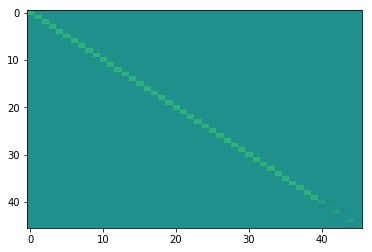

In [67]:
import numpy as np
import time

# Number of factors r
r = len(nlevels)
print(nlevels)
print(nparams)
n=Z.shape[0]

q = np.sum(np.dot(nparams,nlevels))
print(q)

Ddict = dict()
for i in np.arange(len(nparams)):
  
  D_tmp = np.random.randn(nparams[i],nparams[i])
  Ddict[i] = D_tmp*D_tmp.transpose()

D = np.array([])
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = Ddict[i]

    else:

      D = scipy.linalg.block_diag(D, Ddict[i])

sigma2 = 1
p = XtX.shape[0]
beta = np.ones((p,1))
      
imshow(D, \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

t1 = time.time()

Xte = XtY - (XtX @ beta)
Zte = ZtY - (ZtX @ beta)
IplusZtZD = np.eye(q) + ZtZ @ D
invIplusZtZD = np.linalg.inv(IplusZtZD)

ete = YtY - 2*YtX @ beta + beta.transpose() @ XtX @ beta

dldB = 1/sigma2*(Xte - (XtZ @ D @ invIplusZtZD @ Zte))

dldsigma2 = -n/(2*sigma2) + 1/(2*(sigma2**2))*(ete - Zte.transpose() @ D @ invIplusZtZD @ Zte)


dldDdict = dict()
# For each factor, factor k, work out dl/dD_k
for k in np.arange(len(nparams)):
  
  # Initalize the derivative to zeros
  dldDk = np.zeros((nparams[k],nparams[k]))
  
  # For each level j we need to add a term
  for j in np.arange(nlevels[k]):
    
    # Get the indices for the kth factor jth level
    Ikj = faclev_indices(k, j, nlevels, nparams)
    
    # Get (the kj^th columns of Z)^T multiplied by Z
    Z_kjtZ = ZtZ[Ikj,:]
    Z_kjte = Zte[Ikj,:]
    
    # Get the first term of the derivative
    sigmainvZ_kjtVinve = 1/np.sqrt(sigma2)*(Z_kjte - Z_kjtZ @ D @ invIplusZtZD @ Zte)
    firstterm = sigmainvZ_kjtVinve @ sigmainvZ_kjtVinve.transpose()
    
    # Get (the kj^th columns of Z)^T multiplied by (the kj^th columns of Z)
    Z_kjtZ_kj = ZtZ[np.ix_(Ikj,Ikj)]
    secondterm = Z_kjtZ_kj - Z_kjtZ @ D @ invIplusZtZD @ Z_kjtZ.transpose()
    
    # Add these to the running sum
    dldDk = dldDk + firstterm + secondterm

  # Halve the sum (the coefficient of a half was not included in the above)
  dldDk = dldDk/2
  
  # Store it in the dictionary
  dldDdict[k] = dldDk

t2 = time.time()
print(t2-t1)
    
print(dldDdict[0])
print(dldDdict[1])

In [0]:
# k and j are both zero indexed
def faclev_indices(k, j, nlevels, nparams):
  
  # Work out the starting point of the indices
  start = np.concatenate((np.array([0]), np.cumsum(nlevels*nparams)))[k] + nparams[k]*j
  
  # work out the end point of the indices
  end = start + nparams[k]
  
  return(np.arange(start, end))

In [45]:
k = 0
j = 3
Z2 = Z.toarray()
e = Y - X @ beta
print(np.sum(np.sum(np.abs(Z2[:,faclev_indices(k, j, nlevels, nparams)].transpose() @ Z2 - ZtZ[faclev_indices(k, j, nlevels, nparams), :]))))

print(np.sum(np.sum(np.abs(Z2[:,faclev_indices(k, j, nlevels, nparams)].transpose() @ e - Zte[faclev_indices(k, j, nlevels, nparams), :]))))

0.0
9.450218385609332e-13


## Calculating the Information matrix

Fisher scoring requires the calculation of the information matrix, $\mathcal{I}$. This is done using the method outlined in [Demidenko 2013](https://www.wiley.com/en-us/Mixed+Models%3A+Theory+and+Applications+with+R%2C+2nd+Edition-p-9781118091579) section 3.3.


### Fisher Information Matrix function

This function calculates the Fisher Information matrix.

---

The following inputs are required for this function:

---

 - **ZtX**: Z transpose multiplied by X.
 - **ZtY**: Z transpose multiplied by Y.
 - **XtX**: X transpose multiplied by X.
 - **ZtZ**: Z transpose multiplied by Z.
 - **XtY**: X transpose multiplied by Y.
 - **YtX**: Y transpose multiplied by X.
 - **YtZ**: Y transpose multiplied by Z.
 - **XtZ**: X transpose multiplied by Z.
 - **YtY**: Y transpose multiplied by Y.

In [0]:
def FisherInfoMat(ZtZ, XtX, XtZ, DupInv, n, sigma2, D):
  
  t1 = time.time()
  # Calculate the R matrix
  R = recursiveInverse(scipy.sparse.identity(ZtZ.shape[0]) + D*ZtZ, nparams, nlevels)*ZtZ
  #R=ZtZ.toarray()
  t2 = time.time()  
  print(t2-t1)  
  print(R.shape)
  
  t1 = time.time()
  # Element (1,1) (1 indexed)
  e11 = XtX + (XtZ @ R) @ XtZ.transpose()
  t2 = time.time()
  print(t2-t1)
  
  # Element (2,2) (1 indexed)
  t1 = time.time()
  e22 = np.array([[n*(sigma2**(-2))]])
  t2 = time.time()
  print(t2-t1)
    
  
  t1 = time.time()
  # Element (2,3) (1 indexed)
  e32 = sigma2**(-1)*DupInv*mat2vec(R)
  t2 = time.time()  
  print(t2-t1)
    
  t1 = time.time()
  # Element (2,3) (1 indexed)
  e23 = e32.transpose()
  t2 = time.time()  
  print(t2-t1)
  
  t1 = time.time()
  # Element (3,3) (1 indexed)
  e33 = DupInv @ scipy.sparse.kron(R,R) @ DupInv.transpose()
  t2 = time.time()  
  print(t2-t1)
  
  print(e33.shape)
  print(type(e33))
  
  t1 = time.time()
  # Fisher information for covariances
  top_cov = np.concatenate((e22, e23),axis=1)
  bottom_cov = np.concatenate((e32, e33),axis=1)
  FI_cov = np.concatenate((top_cov,bottom_cov),axis=0)
  t2 = time.time()  
  print(t2-t1)
  
  # Add the beta element 
  t1 = time.time()
  FI = scipy.linalg.block_diag(e11, FI_cov)
  t2 = time.time()
  print(t2-t1)
    
  return(FI)
  
# Example
print(ZtZ.shape[0])
print(nparams)
print(nlevels)
print(XtZ.shape)
t1 = time.time()
# Calculate Dup^+
DupInv = invDupMat(Z.shape[1])
t2 = time.time()  
print(t2-t1)
t1=time.time()
FisherInfoMat(ZtZ, XtX, XtZ, DupInv, 100, 1, scipy.sparse.identity(ZtZ.shape[0]))
t2=time.time()
print(t2-t1)

In [0]:
Z.size


print(nparams)
print(np.int64(nparams*(nparams+1)/2))
#print(nlevels)

Ddict = dict()
for i in np.arange(len(nparams)):
  
  D_tmp = np.random.randn(nparams[i],nparams[i])
  Ddict[i] = D_tmp*D_tmp.transpose()

D = np.array([])
for i in np.arange(len(nparams)):
  
  for j in np.arange(nlevels[i]):
    
    if i == 0 and j == 0:

      D = Ddict[i]

    else:

      D = scipy.linalg.block_diag(D, Ddict[i])
      
print(D)


imshow(D, \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')

ZDZt = Z @ D @ Z.transpose()

ZDZt2 = np.zeros(ZDZt.shape)
currentcol=0
for j in np.arange(len(nparams)):
  
  for i in np.arange(nlevels[j]):
    imshow(Z[:,currentcol:(currentcol+nparams[j])] @ Ddict[j] @ Z[:,currentcol:(currentcol+nparams[j])].transpose(), \
       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')
    ZDZt2 = ZDZt2 + Z[:,currentcol:(currentcol+nparams[j])] @ Ddict[j] @ Z[:,currentcol:(currentcol+nparams[j])].transpose()
    currentcol = currentcol+nparams[j]
    
print(np.sum(np.sum(np.abs(ZDZt2-ZDZt))))

#print(Z.transpose().toarray() @ Z.toarray())
#print(Z[:,0:nparams[0]].toarray().transpose() @ Z.toarray())



#imshow(ZDZt2, \
#       interpolation='nearest', vmin=-5, vmax=5, aspect='auto')


In [0]:
imshow(Z.transpose().toarray() @ Z.toarray(), \
   interpolation='nearest', aspect='auto')
plt.colorbar()

In [0]:
print(Z.shape)
imshow(Z[:,0:10].toarray().transpose() @ Z.toarray(), \
   interpolation='nearest', aspect='auto')
plt.colorbar()

tmp = Z.transpose().toarray() @ Z.toarray()
print(tmp[0:10,:]-Z[:,0:10].toarray().transpose() @ Z.toarray())

In [0]:
imshow(Z[:,40:43].toarray().transpose() @ Z[:,1:3].toarray(), \
   interpolation='nearest', aspect='auto')
plt.colorbar()


In [0]:
print(tmp[40:42,0:2])

print(Z[:,40:42].shape)

print(Z[:,40:42].toarray())
print(Z[:,0:2].shape)

print(Z[:,0:2].toarray())



In [0]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
X = np.random.randn(10,9)

XkX = np.kron(X,X)

#print(XkX.shape[0]^2)

#print(XkX.shape[0]**2)
#print(np.power(XkX.shape[0],2))

R = (np.arange(XkX.shape[0]))
#print(R)

#print(R.shape)
Rt = mat2vec(vec2mat(R).transpose())

perm = np.argsort(Rt.reshape(Rt.shape[0]))

K = np.eye(R.shape[0],R.shape[0])
K=K[:,perm]

#print(perm)

imshow(K, \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

#print(K @ R.reshape(R.shape[0],1) - Rt.reshape(R.shape[0],1))

R = (np.arange(XkX.shape[1]))
#print(R)

#print(R.shape)
Rt = mat2vec(vec2mat(R).transpose())

perm = np.argsort(Rt.reshape(Rt.shape[0]))

K2 = np.eye(R.shape[0],R.shape[0])
K2=K2[:,perm]

#print(perm)

imshow(K2, \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

#print(K2 @ R.reshape(R.shape[0],1) - Rt.reshape(R.shape[0],1))

N = (K + np.eye(K.shape[0]))/2
N2 = (K2 + np.eye(K2.shape[0]))/2

#print(K.shape)
#print(K2.shape)
#print(XkX.shape)
print((N @ XkX))
#print((N @ XkX).shape)
#print((XkX @ N2).shape)

print((XkX @ N2)-(N @ XkX))

In [0]:
X = np.random.randn(100,100)

imshow(np.kron(X,X)[1:100,1:100], \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

In [0]:
imshow(np.kron(X[1:10,1:10],X[1:10,1:10]), \
   interpolation='nearest', aspect='auto',vmax=2,vmin=-1)
plt.colorbar()

## Scaling up the computation (Multiple voxels)

This section has several implemented ideas for scaling up the computation to compute several similar models at once. For simplicity it is assumed here that X and Z are the same across voxels.

### Toy data for Neighbouring voxel

To assess the potential of the following ideas a toy data example is created below. The idea behind this is that we wish to calculate both the model in the example used in the previous sections and, additionally a similar model from a neighbouring voxel (variables related to the neighbouring voxel will have postfix `_n`). 

This is not a rigourous test, but just a toy example to see if we can lower the computational time in an example vaguely similar to what we may expect in reality.

#### Beta vector

In a neighbouring voxel, we would expect similar Beta values but not necessarily the same. To simulate this, I have added some normal noise with variance, 1/2, to the original beta values to obtain a new beta value.

In [0]:
# Given a beta vector this function makes a beta 
# vector for the neighbouring voxel
def beta_n(beta):
  return(beta + np.random.randn(beta.shape[0],1)/np.sqrt(2))

# Example
beta_True_n = beta_n(beta_True)
  
# print betas for comparison
print("Beta for voxel 1")
print(beta_True)
print("Beta for voxel 2")
print(beta_True_n)

#### b vector

In a neighbouring voxel, we may also expect similar b values. To simulate this, I have added some normal noise with variance, 1/2, to the original b values to obtain a new b value.

In [0]:
# Given a b vector this function makes a b
# vector for the neighbouring voxel
def b_n(b):
  return(b + np.random.randn(b.shape[0],1)/np.sqrt(2))

# Example
b_True_n = b_n(b_True)
  
# print bs for comparison
print("b for voxel 1 (first 5 elements)")
print(b_True[1:5])
print("b for voxel 2 (first 5 elements)")
print(b_True_n[1:5])

 #### Y vector (New response)
 
I now generate a new response vector with the new beta and b values for the neighbouring voxel.

In [0]:
# Neighbouring voxels response vector
Y_n = np.matmul(X,beta_True_n)+Z*b_True_n+np.random.randn(1000,1)


### Product Matrices

All products of matrices are calculated beforehand as it is both more computationally efficient and also similar to the setting we are interested in. For the neighbouring voxel only those involving the Y vector (response) need be recalculated as X and Z have not changed between voxel in this example.

In [0]:
# Z tranpose Y_n
ZtY_n=cvxopt.spmatrix.trans(Z)*Y_n

# X tranpose Y_n
XtY_n=cvxopt.matrix.trans(X)*Y_n

# Y_n tranpose X
YtX_n=cvxopt.matrix.trans(Y_n)*X

# Y_n transpose Z
YtZ_n=cvxopt.matrix.trans(Y_n)*Z

# Y_n tranpose Y_n
YtY_n=cvxopt.matrix.trans(Y_n)*Y_n

#### Time efficiency

What is really important here is not the estimate values (assuming they are correct), but the time taken to do this for both voxels. In the below, the two voxels are estimated 100 times twice, once reusing the estmate from the first voxel in estimating the second, and once computing the voxels completely seperately.

**Conclusion:** 

#### Idea 1: Broadcast everything

The title for this idea speaks for itself. The `scipy` library does not allow for broadcasting of sparse matrices, however the libraries `sparse` and `dask` supposedly do (little documentation is available for this however). If these can be used for broadcasting then this algorithm might be reasonably streamlinable for large numbers of voxels.

In [0]:
# TODO